## **Define ASR Model**

In [1]:
!pip install -q datasets bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline, WhisperForConditionalGeneration, WhisperProcessor
from google.colab import drive
import time

# Google Drive Env Setup
whisper_ver = 'whisper-base'
checkpoint_num = '2100'
google_drive_path = f'/content/drive/My Drive/{whisper_ver}-checkpoints'
drive.mount('/content/drive')
checkpoint_path = f'/content/drive/My Drive/{whisper_ver}-checkpoints/checkpoint-{checkpoint_num}'

# Model setup code for fine-tuned whisper
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = WhisperForConditionalGeneration.from_pretrained(checkpoint_path).to(device)
model.config.use_cache = True
processor = WhisperProcessor.from_pretrained(f"openai/{whisper_ver}", language="en", task="transcribe")

Mounted at /content/drive


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

## **Define Dataset**

In [ ]:
'''
from datasets import load_dataset
# Define dataset for testing
dataset_repo = "johnlohjy/imda_nsc_p3_same_closemic_test"
dataset = load_dataset(dataset_repo, split='test', streaming=True, trust_remote_code=True)
dataset_iter = iter(dataset)
sample = next(dataset_iter)
sample = sample["audio"]
'''

In [ ]:
'''
# Convert to sample to wav file
import wave
import scipy.io.wavfile as wav
import numpy as np
wav.write('sample.wav', sample["sampling_rate"], (sample["array"] * 32767).astype(np.int16))
'''

## **Sample Transcription**

In [ ]:
'''
Transcribe sample

start_time = time.time()
input_features = processor.feature_extractor(sample["array"], sampling_rate=16000).input_features[0]
input_features = torch.tensor(input_features).unsqueeze(0).to(device)
generated_ids = model.generate(input_features)
predicted_transcription = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
stop_time = time.time()
print(predicted_transcription)
print(f'\n The time taken is {stop_time-start_time}')
'''

In [ ]:
'''
import torchaudio
filename = './sample.wav'
waveform, sample_rate = torchaudio.load(filename)
start_time = time.time()
input_features = processor.feature_extractor(waveform.numpy(), sampling_rate=16000).input_features[0]
input_features = torch.tensor(input_features).unsqueeze(0).to(device)
generated_ids = model.generate(input_features)
predicted_transcription = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
stop_time = time.time()
print(predicted_transcription)
print(f'\n The time taken is {stop_time-start_time}')
'''

In [30]:
'''
import torchaudio
filename = './sample.wav'
waveform, sample_rate = torchaudio.load(filename)
print(waveform.numpy())
print(type(waveform.numpy()))
'''

[[-6.1035156e-05 -9.1552734e-05 -6.1035156e-05 ...  2.7465820e-04
   2.7465820e-04  2.1362305e-04]]
<class 'numpy.ndarray'>


In [60]:
# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound


def bytes_to_float_array(data):
    """
    Converts the given byte string to a NumPy float32 array.
    (Ensure the dtype matches your audio format.)
    """
    return int2float(np.frombuffer(data, dtype=np.int16))

filename = "./sample.wav"
chunk = 48000 #4096


with wave.open(filename, "rb") as wavfile:
  while True:
    data = wavfile.readframes(chunk)
    audio_array = bytes_to_float_array(data)
    audio_array = audio_array.tobytes()
    frame_data = np.frombuffer(audio_array, dtype=np.float32)
    input_features = processor.feature_extractor(frame_data, sampling_rate=16000).input_features[0]
    input_features = torch.tensor(input_features).unsqueeze(0).to(device)
    generated_ids = model.generate(input_features)
    predicted_transcription = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(predicted_transcription)


you know ya she was from
 friends so that's to share with me
 about her culture lah so you know
uh she would show me around when she would
when i would visit lah when i travel the france
locking forward that as
it's really not interesting generation gap
yeah what's the biggest similarity or difference between
generation and your parent's generation okay
okay


ValueError: zero-size array to reduction operation maximum which has no identity

In [61]:
# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound


def bytes_to_float_array(data):
    """
    Converts the given byte string to a NumPy float32 array.
    (Ensure the dtype matches your audio format.)
    """
    return int2float(np.frombuffer(data, dtype=np.int16))

filename = "./sample.wav"
chunk = 48000 #4096


with wave.open(filename, "rb") as wavfile:
  while True:
    data = wavfile.readframes(chunk)
    frame_data = np.frombuffer(bytes_to_float_array(data), dtype=np.float32)
    input_features = processor.feature_extractor(frame_data, sampling_rate=16000).input_features[0]
    input_features = torch.tensor(input_features).unsqueeze(0).to(device)
    generated_ids = model.generate(input_features)
    predicted_transcription = processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print(predicted_transcription)

you know ya she was from
 friends so that's to share with me
 about her culture lah so you know
uh she would show me around when she would
when i would visit lah when i travel the france
locking forward that as
it's really not interesting generation gap
yeah what's the biggest similarity or difference between
generation and your parent's generation okay
okay


ValueError: zero-size array to reduction operation maximum which has no identity

In [55]:
filename = "sample.wav"

with wave.open(filename, "rb") as wavfile:
    sample_width = wavfile.getsampwidth()
    print(f"Sample Width: {sample_width} bytes per sample")

    if sample_width == 2:
        print("Format: int16 (PCM 16-bit)")
    elif sample_width == 4:
        print("Format: float32 (PCM 32-bit)")
    else:
        print(f"Unknown format with sample width: {sample_width}")

Sample Width: 2 bytes per sample
Format: int16 (PCM 16-bit)


## **Define VAD model-related dependencies**

In [3]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00


In [4]:
import torch
import torchaudio
from typing import Callable, List
import warnings
import numpy as np
import onnxruntime


class OnnxWrapper():
    '''
    Code taken from: https://github.com/snakers4/silero-vad/blob/master/src/silero_vad/utils_vad.py

    See https://github.com/collabora/WhisperLive/blob/main/whisper_live/vad.py
    '''
    def __init__(self, path, force_onnx_cpu=False):
        opts = onnxruntime.SessionOptions()
        opts.inter_op_num_threads = 1
        opts.intra_op_num_threads = 1

        if force_onnx_cpu and 'CPUExecutionProvider' in onnxruntime.get_available_providers():
            self.session = onnxruntime.InferenceSession(path, providers=['CPUExecutionProvider'], sess_options=opts)
        else:
            self.session = onnxruntime.InferenceSession(path, sess_options=opts)

        self.reset_states()
        if '16k' in path:
            warnings.warn('This model support only 16000 sampling rate!')
            self.sample_rates = [16000]
        else:
            self.sample_rates = [8000, 16000]

    def _validate_input(self, x, sr: int):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            raise ValueError(f"Too many dimensions for input audio chunk {x.dim()}")

        if sr != 16000 and (sr % 16000 == 0):
            step = sr // 16000
            x = x[:,::step]
            sr = 16000

        if sr not in self.sample_rates:
            raise ValueError(f"Supported sampling rates: {self.sample_rates} (or multiply of 16000)")
        if sr / x.shape[1] > 31.25:
            raise ValueError("Input audio chunk is too short")

        return x, sr

    def reset_states(self, batch_size=1):
        self._state = torch.zeros((2, batch_size, 128)).float()
        self._context = torch.zeros(0)
        self._last_sr = 0
        self._last_batch_size = 0

    def __call__(self, x, sr: int):

        x, sr = self._validate_input(x, sr)
        num_samples = 512 if sr == 16000 else 256

        if x.shape[-1] != num_samples:
            raise ValueError(f"Provided number of samples is {x.shape[-1]} (Supported values: 256 for 8000 sample rate, 512 for 16000)")

        batch_size = x.shape[0]
        context_size = 64 if sr == 16000 else 32

        if not self._last_batch_size:
            self.reset_states(batch_size)
        if (self._last_sr) and (self._last_sr != sr):
            self.reset_states(batch_size)
        if (self._last_batch_size) and (self._last_batch_size != batch_size):
            self.reset_states(batch_size)

        if not len(self._context):
            self._context = torch.zeros(batch_size, context_size)

        x = torch.cat([self._context, x], dim=1)
        if sr in [8000, 16000]:
            ort_inputs = {'input': x.numpy(), 'state': self._state.numpy(), 'sr': np.array(sr, dtype='int64')}
            ort_outs = self.session.run(None, ort_inputs)
            out, state = ort_outs
            self._state = torch.from_numpy(state)
        else:
            raise ValueError()

        self._context = x[..., -context_size:]
        self._last_sr = sr
        self._last_batch_size = batch_size

        out = torch.from_numpy(out)
        return out

    def audio_forward(self, x, sr: int):
        outs = []
        x, sr = self._validate_input(x, sr)
        self.reset_states()
        num_samples = 512 if sr == 16000 else 256

        if x.shape[1] % num_samples:
            pad_num = num_samples - (x.shape[1] % num_samples)
            x = torch.nn.functional.pad(x, (0, pad_num), 'constant', value=0.0)

        for i in range(0, x.shape[1], num_samples):
            wavs_batch = x[:, i:i+num_samples]
            out_chunk = self.__call__(wavs_batch, sr)
            outs.append(out_chunk)

        stacked = torch.cat(outs, dim=1)
        return stacked.cpu()




class VoiceActivityDetector:
    '''
    See https://github.com/collabora/WhisperLive/blob/main/whisper_live/vad.py

    Onxx model:
    '''
    def __init__(self, path, threshold=0.5, frame_rate=16000):
        """
        Initializes the VoiceActivityDetector with a voice activity detection model and a threshold.

        Args:
            threshold (float, optional): The probability threshold for detecting voice activity. Defaults to 0.5.
        """
        self.model = OnnxWrapper(path=path,force_onnx_cpu=True)
        self.threshold = threshold
        self.frame_rate = frame_rate

    def __call__(self, audio_frame):
        """
        Determines if the given audio frame contains speech by comparing the detected speech probability against
        the threshold.

        Args:
            audio_frame (np.ndarray): The audio frame to be analyzed for voice activity. It is expected to be a
                                      NumPy array of audio samples.

        Returns:
            bool: True if the speech probability exceeds the threshold, indicating the presence of voice activity;
                  False otherwise.
        """
        speech_probs = self.model.audio_forward(torch.from_numpy(audio_frame.copy()), self.frame_rate)[0]
        return torch.any(speech_probs > self.threshold).item()

In [5]:
import numpy as np
#from vad import VoiceActivityDetector

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

# Load the Silero VAD model
vad_model_path = './silero_vad.onnx'
vad_detector = VoiceActivityDetector(vad_model_path)

## **Test VAD**

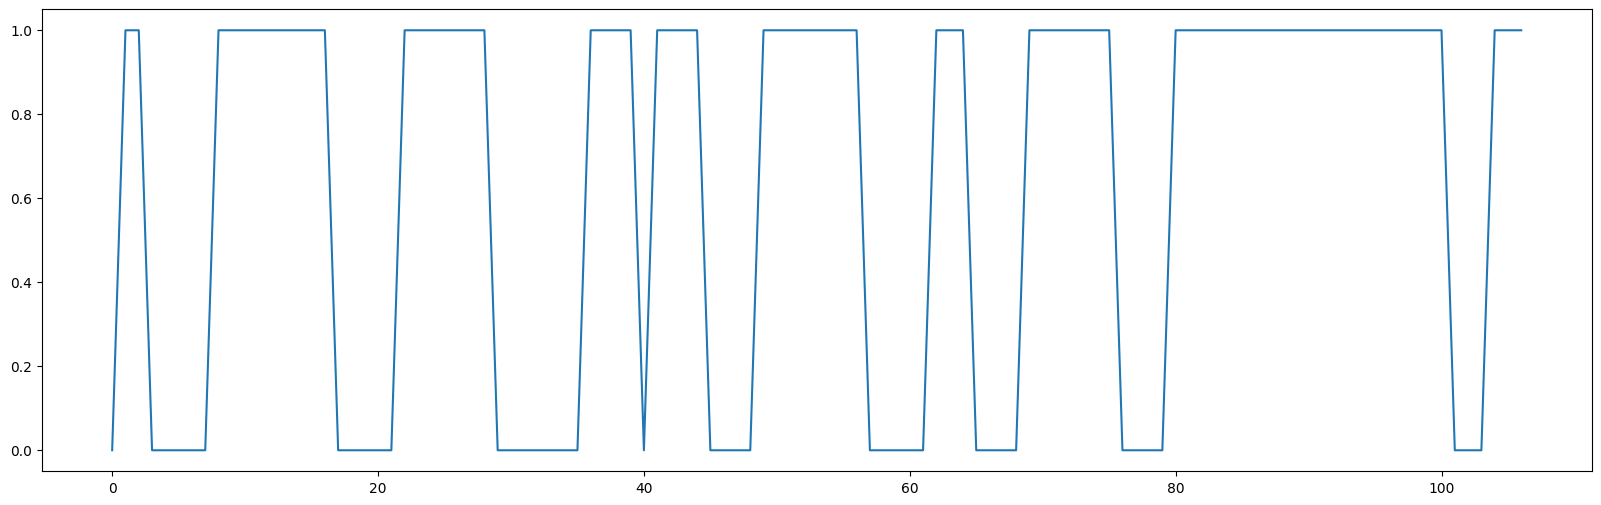

In [59]:
# https://github.com/snakers4/silero-vad/blob/master/examples/microphone_and_webRTC_integration/microphone_and_webRTC_integration.py
# https://github.com/snakers4/silero-vad/blob/master/examples/pyaudio-streaming/pyaudio-streaming-examples.ipynb

import matplotlib.pylab as plt
chunk = 4096

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

def bytes_to_float_array(data):
    """
    Converts the given byte string to a NumPy float32 array.
    (Ensure the dtype matches your audio format.) -> todo: IMPORTANT!!!
    """
    return int2float(np.frombuffer(data, dtype=np.int16)), np.frombuffer(data,dtype=np.int16)

voiced_confidences = []

filename = "./sample.wav"
with wave.open(filename, "rb") as wavfile:
  while True:
      data = wavfile.readframes(chunk)
      if data == b"":
          break

      audio_array_transcription, audio_array_vad = bytes_to_float_array(data)
      audio_array_vad = audio_array_vad.tobytes()
      audio_array = int2float(np.frombuffer(audio_array_vad, dtype=np.int16))
      new_confidence = vad_detector(audio_array)
      if new_confidence:
          voiced_confidences.append(1)
      else:
          voiced_confidences.append(0)


plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()

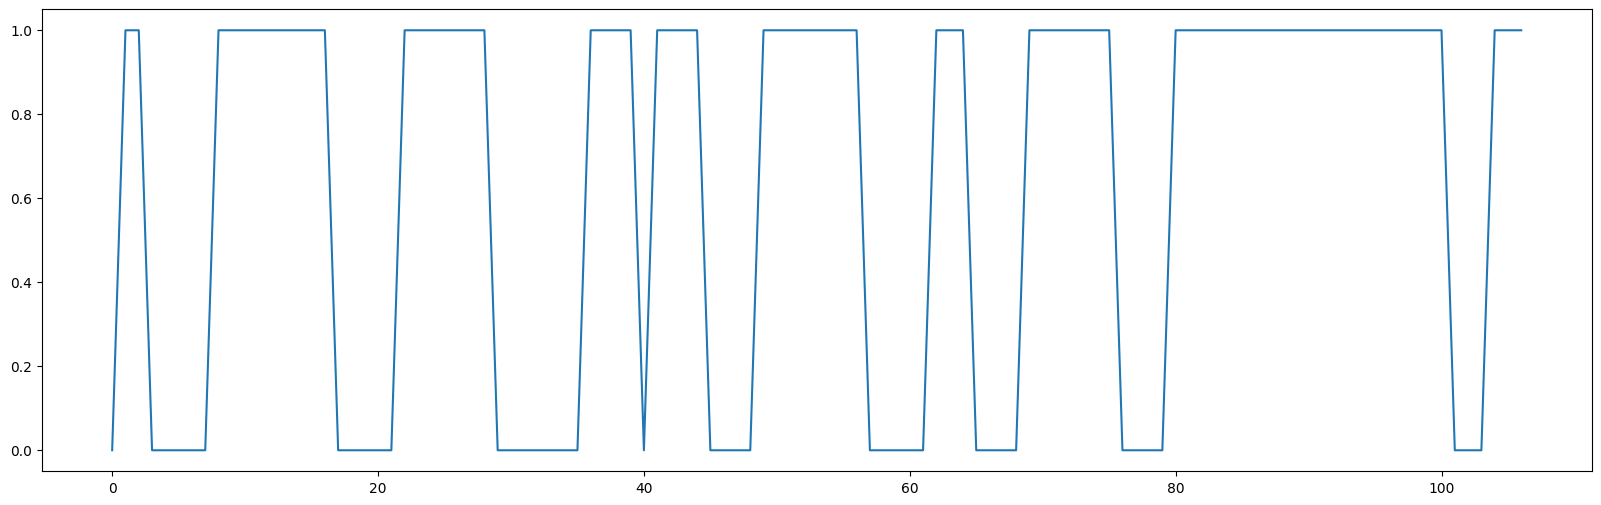

In [62]:
# https://github.com/snakers4/silero-vad/blob/master/examples/microphone_and_webRTC_integration/microphone_and_webRTC_integration.py
# https://github.com/snakers4/silero-vad/blob/master/examples/pyaudio-streaming/pyaudio-streaming-examples.ipynb

import matplotlib.pylab as plt
chunk = 4096

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

def bytes_to_float_array(data):
    """
    Converts the given byte string to a NumPy float32 array.
    (Ensure the dtype matches your audio format.) -> todo: IMPORTANT!!!
    """
    return int2float(np.frombuffer(data, dtype=np.int16)), np.frombuffer(data,dtype=np.int16)

voiced_confidences = []

filename = "./sample.wav"
with wave.open(filename, "rb") as wavfile:
  while True:
      data = wavfile.readframes(chunk)
      if data == b"":
          break

      audio_array = int2float(np.frombuffer(data, dtype=np.int16))
      new_confidence = vad_detector(audio_array)
      if new_confidence:
          voiced_confidences.append(1)
      else:
          voiced_confidences.append(0)


plt.figure(figsize=(20,6))
plt.plot(voiced_confidences)
plt.show()

## **Define Server-Related Classes, Adapted for Colab**

In [78]:
import json
import numpy as np
import os
import wave
import threading
import textwrap

class Client:
    def __init__(self, transcriber=model, transcriber_processor=processor, send_last_n_segments=3):
        '''
        In charge of adding audio chunks, managing the audio buffer, adjusting the amount of audio to transcribe,
        transcribing the audio, printing the latest segment + send_last_n_segments,

        when a prolonged silence is encountered
        - save the latest (finalized) transcription
        - update timestamp_offset to go past the transcription
        '''
        self.frames_np = None # Store frames buffer as a numpy array
        self.frames_offset = 0.0 # Track frames offset from the very start/Duration of audio discarded
        self.timestamp_offset = 0.0 # Track transcription offset from the very start
        self.send_last_n_segments = send_last_n_segments  # Number of last transcribed segments that will be 'sent' to the client
        self.eos = False # End-Of-Speech Flag
        self.transcriber = transcriber # Initialize Whisper ASR model
        self.transcriber_processor = transcriber_processor # Initialize Whisper ASR processor
        self.transcript = [] # Store fully transcribed segments
        self.lock = threading.Lock() # for shared resources: frames_np. https://realpython.com/python-thread-lock/#threadinglock-for-primitive-locking
        self.RATE = 16000

        # SINGLE_MODEL = None # only necessary for multiple clients?
        # SINGLE_MODEL_LOCK = threading.Lock() # only necessary for multiple clients?

        # Thread to run speech-to-text function
        '''
        Main Entry point
        '''
        self.trans_thread = threading.Thread(target=self.speech_to_text)
        self.trans_thread.start()


    def add_frames(self, frame_np):
        '''
        Manage the ongoing buffer's size - update frames_offset and timestamp_offset as necessary
        Add new audio chunks to the client's frames buffer
        '''
        # Manage the ongoing buffer
        # Lock required as frames_np, frames_offset, timestamp_offset is a shared resource with the speech_to_text thread code
        # lock the critical section of code below (lock shared resources, no 2 threads can modify)
        self.lock.acquire()
        # If the buffer is more than 45s
        if self.frames_np is not None and self.frames_np.shape[0] > 45*self.RATE:
            # Increase frames_offset by 30s
            # Discard oldest 30s of audio from buffer
            self.frames_offset += 30.0
            self.frames_np = self.frames_np[int(30*self.RATE):]
            # Update timestamp_offset
            if self.timestamp_offset < self.frames_offset:
                self.timestamp_offset = self.frames_offset

        # If the frame buffer is empty, initialise it with the new audio frames
        if self.frames_np is None:
            self.frames_np = frame_np.copy()
        # Else, append the new audio chunk to the existing buffer
        else:
            self.frames_np = np.concatenate((self.frames_np, frame_np), axis=0)
        # unlock the critical section of code above
        self.lock.release()


    def speech_to_text(self):
        '''
        Process audio buffer in an infinite loop, continuously transcribing speech
        - Adjust timestamp_offset s.t there is an appropriate amount of audio to transcribe
        - Get the audio to be transcribed
        - Transcribe the audio to be transcribed
        - Print the latest segment along with the send_last_n_segments

        If the client's end-of-speech flag is True
        (prolonged silence, means that speech segment is finalized),
        - Save the latest speech segment
        - Update the timestamp_offset as this portion of the buffer has been finalized
        (doesn't need to be transcribed anymore)
        '''
        while True:
            # Wait for some chunks to arrive
            if self.frames_np is None:
                time.sleep(0.02)
                continue

            # Adjust the timestamp_offset
            self.clip_audio_if_no_valid_segment()

            # Get the audio to be transcribed using the timestamp_offset
            input_bytes, duration = self.get_audio_chunk_for_processing()
            if duration < 0.4:
                continue

            # Transcribe the audio, print the transcriptions to be printed,
            # Update the timestamp_offset if prolonged silence was encountered
            # - it means the latest segment is finalized
            input_sample = input_bytes.copy()
            self.transcribe_audio(input_sample, duration)


    def clip_audio_if_no_valid_segment(self):
        '''
        If there is > 25s of audio to transcribe in the buffer,
        adjust timestamp_offset such that its only 5s behind the total audio added so far

        If there is <=25s of audio to transcribe, its okay
        '''
        # Lock is required because frames_np, frames_offset, timestamp_offset is a shared resource
        # Written as a context manager -> Auto acquires and release lock
        with self.lock:
            # If there is more than 25s of audio to transcribe
            if self.frames_np[int((self.timestamp_offset - self.frames_offset)*self.RATE):].shape[0] > 25 * self.RATE:
                # Adjust timestamp_offset s.t it is only 5s behind the total audio added so far
                duration = self.frames_np.shape[0] / self.RATE
                self.timestamp_offset = self.frames_offset + duration - 5


    def get_audio_chunk_for_processing(self):
        '''
        Get the audio to be transcribed from the buffer calculated using timestamp_offset
        '''
        # Use timestamp_offset to help subset the buffer to get the audio to be transcribed
        # Lock is required because frames_np, frames_offset, timestamp_offset is a shared resource
        # Written as a context manager -> Auto acquires and release lock
        with self.lock:
            samples_take = max(0, (self.timestamp_offset - self.frames_offset) * self.RATE)
            input_bytes = self.frames_np[int(samples_take):].copy()
        duration = input_bytes.shape[0] / self.RATE
        return input_bytes, duration


    def transcribe_audio(self, input_bytes, duration):
        '''
        Transcribe the audio to be transcribed
        '''
        # Transcribe the audio to be transcribed
        # last_segment = self.transcriber.transcribe(input_bytes)
        input_features = self.transcriber_processor.feature_extractor(input_bytes, sampling_rate=16000).input_features[0]
        input_features = torch.tensor(input_features).unsqueeze(0).to(device)
        generated_ids = self.transcriber.generate(input_features)
        last_segment = self.transcriber_processor.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Print the transcriptions to be printed and
        # if there is prolonged silence,
        # - Save the latest speech segment
        # - Update the timestamp_offset
        self.handle_transcription_output(last_segment, duration)


    def handle_transcription_output(self, last_segment, duration):
        '''
        Print the transcriptions to be printed
        If the client's end-of-speech flag is True
        (prolonged silence, means that speech segment is finalized),
        - Save the latest speech segment
        - Update the timestamp_offset
        '''
        segments = self.prepare_segments({"text": last_segment})
        self.send_transcription_to_client(segments)
        if self.eos:
            self.update_timestamp_offset(last_segment, duration)


    def prepare_segments(self, last_segment=None):
        '''
        Prepare the segments to be printed
        '''
        segments = []
        # If the length of self.transcript is more than or equal send_last_n_segments,
        # set segments to be the last send_last_n_segments number of elements of self.transcript
        if len(self.transcript) >= self.send_last_n_segments:
            segments = self.transcript[-self.send_last_n_segments:].copy()
        # If not, just set segments to be self.transcript
        else:
            segments = self.transcript.copy()
        # If the segment that was just transcribed is not None, add it to segments
        if last_segment is not None:
            segments = segments + [last_segment]
        return segments


    def send_transcription_to_client(self, text):
        '''
        Print the transcription for testing on Colab
        '''

        '''
        wrapper = textwrap.TextWrapper(width=60)
        for line in wrapper.wrap(text="".join(text)):
            print(line)
        print('')
        print('')
        '''
        print(text)



    def update_timestamp_offset(self, last_segment, duration):
        # If self.transcript is empty, add the last segment received
        if not len(self.transcript):
            self.transcript.append({"text": last_segment + " "})
        # If the last element of self.transcript is != to the last segment, add the last segment
        elif self.transcript[-1]["text"].strip() != last_segment:
            self.transcript.append({"text": last_segment + " "})
        # Lock is required because frames_np, frames_offset, timestamp_offset is a shared resource
        # Written as a context manager -> Auto acquires and release lock
        # Update the timestamp_offset as this portion of the buffer has been finalized
        # (doesn't need to be transcribed anymore)
        with self.lock:
            self.timestamp_offset += duration


    def set_eos(self, eos):
        """
        Sets the End of Speech (EOS) flag.

        Args:
            eos (bool): The value to set for the EOS flag.
        """
        self.lock.acquire()
        self.eos = eos
        self.lock.release()




class ClientManager:
    '''
    Custom client manager class to handle clients connected over the
    WebSocket server
    '''
    def __init__(self):
        self.clients = {}

    def add_client(self, websocket, client):
        '''
        Add a WebSocket server connection info and its associated client
        '''
        self.clients[websocket] = client

    def get_client(self, websocket):
        '''
        Retrieve a client associated with the WebSocket server connection info provided
        '''
        if websocket in self.clients:
            return self.clients[websocket]
        return False




class Server:
    def __init__(self, vad_detector):
        '''
        In charge of receiving, checking VA and passing audio to client
        '''
        self.client_manager = None
        self.vad_detector = vad_detector # VAD detector
        self.no_voice_activity_chunks = 0 # Help to track prolonged silence
        self.no_voice_activity_threshold = 3


    def recv_audio(self, websocket, audio_array):
        """
        Entry point for transcription
        Handle the new connection
        Continously process audio frames

        tochange: audio_array is passed because we can't use a websocket in colab
        """
        # Handle the new connection
        if not self.handle_new_connection(websocket):
            return

        # Continously process audio frames
        '''
        Issue with running on colab: Because audio_array is passed to recv_audio
        then, process_audio_frames only receives one instance of audio_array
        and gets stuck in a loop

        Maybe instead, set up the clients outside the audio loop and then call process_audio_frames
        directly
        '''
        while True:
            if not self.process_audio_frames(websocket, audio_array):
                break


    def handle_new_connection(self,websocket):
        '''
        Initialise the client manager
        Set the VAD
        Initialise the new client and add it to the client manager
        '''

        # Initialise the client manager if not done
        if self.client_manager is None:
            self.client_manager = ClientManager()

        # Initialise the new client and add it to the client manager.
        # The websocket acts as the key
        self.initialize_client(websocket)

        return True


    def initialize_client(self, websocket):
        '''
        Initialize the new client and add it to the client manager
        '''
        # Initialize the new client
        client = Client()

        # Add the client to the client manager
        self.client_manager.add_client(websocket, client)


    def process_audio_frames(self, websocket, audio_array):
        '''
        Responsible for
        - checking voice activity
        - adding audio chunks to the retrieved client's buffer

        Get the audio chunk from the WebSocket
        If it has voice activity
        - Reset the no voice activity settings
        - Add the audio chunk to the client's buffer
        - return True
        If it has no voice activity
        - return True
        '''
        # Get the audio chunk from the WebSocket as a numpy array
        # tochange: audio_array is passed because we can't use a websocket in colab
        frame_np, audio_float32 = self.get_audio_from_websocket(websocket, audio_array)

        # Get the client using its associated WebSocket
        client = self.client_manager.get_client(websocket)

        # Check for voice activity in the audio chunk
        # - if there is no voice activity return False
        # - if there is prolonged silence (accumulated), set the eos flag of the client to True
        # - if there is voice activity return True
        voice_active = self.voice_activity(websocket, audio_float32, self.no_voice_activity_threshold)

        # If there is voice activity, reset the
        # - no_voice_activity_chunks
        # - eos flag
        # - add audio chunk to the client's buffer
        if voice_active:
            self.no_voice_activity_chunks = 0
            client.set_eos(False)
            client.add_frames(frame_np)
        return True


    def get_audio_from_websocket(self, websocket, frame_data):
        '''
        Receive audio chunks from the WebSocket and create a numpy array out of it
        '''
        # Subsequently, receive audio data (message) over the WebSocket server connection
        # tochange: audio_array/frame_data is passed because we can't use a websocket in colab
        # frame_data = websocket.recv()
        # Creates numpy array without copying it (more efficient)
        # MAKE SURE DATA FORMATS ARE CORRECT
        # VAD:
        # - https://github.com/snakers4/silero-vad/blob/master/examples/pyaudio-streaming/pyaudio-streaming-examples.ipynb
        # - https://github.com/snakers4/silero-vad/blob/master/examples/microphone_and_webRTC_integration/microphone_and_webRTC_integration.py
        return ( np.frombuffer(int2float(np.frombuffer(frame_data, dtype=np.int16)), dtype=np.float32), int2float(np.frombuffer(frame_data, dtype=np.int16)) )


    def voice_activity(self, websocket, frame_np, no_voice_activity_threshold=3):
        '''
        Whenever no voice activity is detected, increment no_voice_activity_chunks

        If the counter is > 3 i.e. prolonged silence:
        - set the end-of-speech flag of the client to True
        - wait for .1 seconds. todo: is this needed

        return False for no voice activity

        return True for voice activity
        '''
        if not self.vad_detector(frame_np):
            self.no_voice_activity_chunks += 1
            if self.no_voice_activity_chunks > no_voice_activity_threshold:
                client = self.client_manager.get_client(websocket)
                if not client.eos:
                    client.set_eos(True)
                time.sleep(0.1)    # Sleep 100m; wait some voice activity
            return False
        return True

## **Loop to simulate sending server audio data (from file) and Server sending client transcription (print)**

In [80]:
chunk = 4096

# Provided by Alexander Veysov
def int2float(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/32768
    sound = sound.squeeze()  # depends on the use case
    return sound

'''
def bytes_to_float_array(data):
    """
    Converts the given byte string to a NumPy float32 array.
    (Ensure the dtype matches your audio format.) -> todo: IMPORTANT!!!
    """
    return int2float(np.frombuffer(data, dtype=np.int16)) #wav file stores in int16. int2float is needed to convert it to float32 format
'''


# Initialise Server
server = Server(vad_detector)
server.handle_new_connection("websocket") # manual call

filename = "./sample.wav"
with wave.open(filename, "rb") as wavfile:
    try:
        while True:
            data = wavfile.readframes(chunk)
            if data == b"":
                break

            # server.recv_audio("websocket", audio_array)
            server.process_audio_frames("websocket", data) # directly call process audio frames with the new audio chunk in bytes

        wavfile.close()
    except KeyboardInterrupt:
        wavfile.close()
        print("KeyboardInterrupt")

[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': 'you know '}, {'text': "ya she was from france so that's"}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': "you know ya she was from france so that she shared with me about our culture lah so you know uh she would show me on when she would when i would visit lah when i travel to france looking forward to that is really not interesting generation gap what's the biggest similarity or difference between your generation and your parent's generation okay"}]
[{'text': 'you know'}]
[{'text': 'you know'}]
[{'text': "you know ya she was from france so that she shared with me about our culture lah so you know uh she would show me on when she would when i would visit lah when i travel to france looking forward to that is really not interesting generation gap what's the bigge